In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from models import *

In [10]:
DATA_PATH = "./data/en_traffic.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["date"])

accident_type = "total"
data = df[
    (df.accident_type == accident_type)
].groupby("date").value.sum()

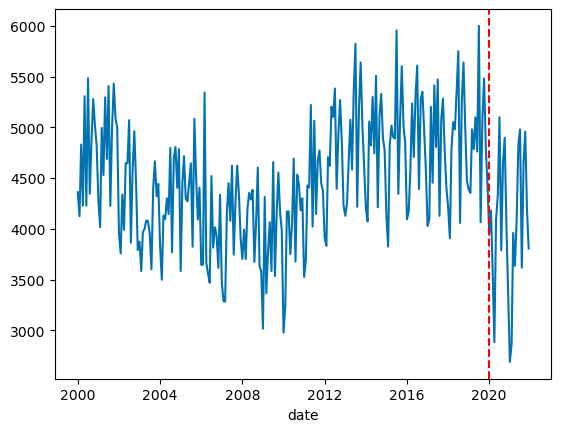

In [11]:
# from https://stackoverflow.com/questions/62473172/modifying-x-ticks-labels-in-seaborn
fig, ax = plt.subplots()
freq = 24
sns.lineplot(x=data.index, y=data.values, ax = ax)
ax.axvline(datetime(2020, 1, 1), color="red", linestyle="--")

# data clearly has a long trend that will not be captured by seasonal
# models. Therefore, the it was decided to use only data from
# the last 10 years.

In [12]:
# "... you can compute the error between the predicted and the the actual values."

data_cut = data.index > "2013-01-01"
recent_data = data[data_cut]
train_cut = recent_data.index >= "2020-01-01"
train, test = recent_data[~train_cut], recent_data[train_cut]

c:\Users\felipe\.conda\envs\dpsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\felipe\.conda\envs\dpsenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


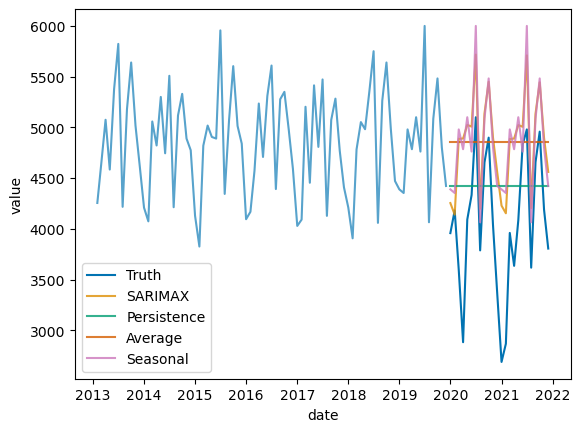

In [13]:
sns.set_palette("colorblind")

fig, ax = plt.subplots()

sns.lineplot(train, alpha = .66)
sns.lineplot(test, c = sns.color_palette()[0], label = "Truth")

n_steps = test.shape[0]

preds_alpha = .8
model_preds = {}

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)).fit()
preds = model.forecast(steps = n_steps)
sns.lineplot(preds, ax=ax, label = "SARIMAX", alpha = preds_alpha)
model_preds["SARIMAX"] = (model, preds)

for model in (Persistence(), Average(12), Seasonal(12)):
    model.fit(train)
    preds = model.forecast(n_steps)
    model_preds[model.name] = (model, preds)
    # FIXME for a reason I don't understand, any style argument
    # is ignored when using seaborn
    # sns.lineplot(preds, alpha=preds_alpha, ax=ax)
    plt.plot(preds.index, preds.values, label = model.name, alpha = preds_alpha)

plt.legend(loc = "lower left")

# `Seasonal` and `SARIMAX` forecasts are very similiar, as expected
# considering how important the seasonal aspect is. `Average` and
# `Persistence` maintain very different values, with `Persistence`
# performing well due to the Pandemic drop.

In [14]:
import pickle
from pathlib import Path

MODEL_PATH = Path("./models")

for name, (model, preds) in model_preds.items():
    rmse = (((preds.values - test.values) ** 2).mean()) ** 0.5
    print(f"{name:}:\t{rmse:.2f}")

    with open(MODEL_PATH / f"{name}.pkl", "wb+") as f:
        pickle.dump(model, f)

# Because of the drop caused by lockdowns during the pandemic
# and the series being low at the end of the year, persistence
# has the best performance. This is not unexpected for the short
# term, but it is clear that the other models (`Seasonal` and 
# `SARIMAX`) have better learned the underlying patterns. Therefore
# a suggestion would be to adjust their prediction by the difference
# between the previous average and the new value (2020-01-01), which
# would be a good approximation for the effect of the pandemic.

SARIMAX:	915.08
Persistence:	766.22
Average:	1045.10
Seasonal:	934.66
